<a href="https://colab.research.google.com/github/Tahahaha7/Quantitative_Trading/blob/main/Portfolio_Optimization_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# $\text{Portfolio Optimization}$

This notebook provides an introduction to portfolio optimization on Python.

## $\text{Installing dependencies}$

In [ ]:
# https://www.youtube.com/watch?v=9fjs8FeLMJk
# https://towardsdatascience.com/algorithmic-trading-based-on-mean-variance-optimization-in-python-62bdf844ac5b

In [ ]:
#%%capture
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar xvzf ta-lib-0.4.0-src.tar.gz

In [ ]:
import os
os.chdir('ta-lib')

In [ ]:
%%capture
!./configure --prefix=/usr
!make
!make install

In [ ]:
os.chdir('../')

In [ ]:
%%capture
!pip install bcolz
!pip install zipline-trader
!pip install PyPortfolioOpt
!pip install pyfolio #pip install git+https://github.com/quantopian/pyfolio
!pip install ta-lib
!pip install empyrical==0.4.1
!pip install yahoofinancials

In [ ]:
# Importing Packages
import numpy as np
import pandas as pd
import talib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import warnings; warnings.filterwarnings("ignore")

# For portfolio Optimization
from pandas_datareader import data
import pypfopt

## $\text{Design Your Portfolio}$

In [ ]:
# Pick a set of 5 stocks to include in your portfolio
assets = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']

# Attribute equal weights for each of the stocks
weights = np.array([1/len(assets)] * len(assets))

# Extract stock prices from Yahoo Finance
df = pd.DataFrame()
for stock in assets:
    df[stock] = data.DataReader(stock,
                                data_source='yahoo',
                                start='2010-01-01',
                                end='2015-01-01'
                                )['Adj Close']

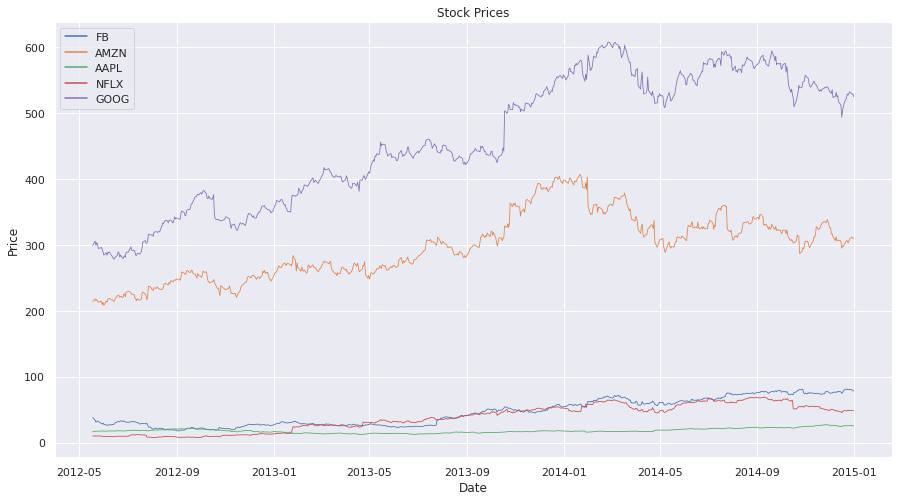

In [ ]:
# Visualize the stocks' prices
plt.figure(figsize=(15, 8))
plt.title('Stock Prices'); plt.ylabel('Price')
ax = sns.lineplot(data=df, dashes=False, lw=.8);

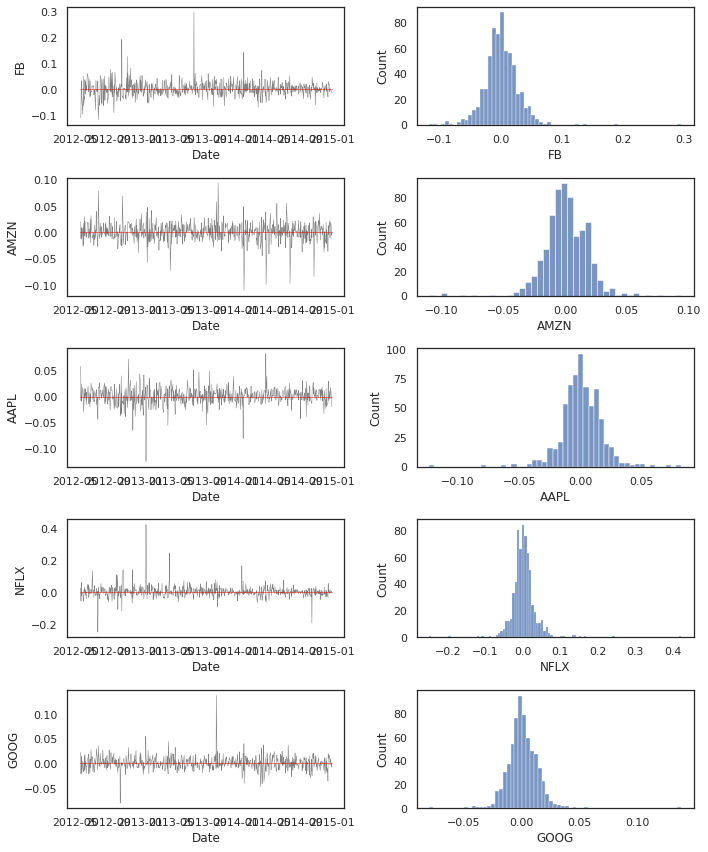

In [ ]:
# Visualize the stocks' return and the distribution of return

idx = 1
sns.set_style('white')
plt.figure(figsize=(2*len(assets), 12))
for stock in assets:
    plt.subplot(5, 2, idx)
    sns.lineplot(data=df.pct_change()[stock], color='Grey', lw=.5)
    sns.lineplot(x=df.pct_change().index, y=0, color='Red', lw=.5)
    plt.subplot(5, 2, idx+1)
    sns.histplot(data=df.pct_change()[stock], bins='auto')
    idx+=2
plt.tight_layout()

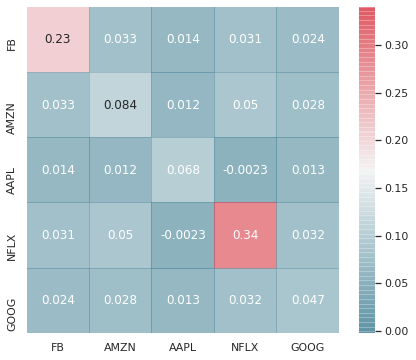

In [ ]:
# Create the annualized covariance matrix

trading_days = 252 # Refers to the number of trading days in a given year
cov_matrix = df.pct_change().cov() * trading_days
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.figure(figsize=(7, 6))
sns.heatmap(cov_matrix, cmap=cmap, alpha=.6, annot=True);

### $\text{Part I}$

The diagonal of the covariance matrix shows the variance of each stock, and if we take the square root of variance then we get the volatility of each stock. The rest of the entries are the covariance for each pair of stocks

1. Calculate the protfolio variance using the following formula:
$$\sigma_p^2=\sum_{i=1}^N\sum_{j=1}^Nw_iw_j\cdot Cov\left(r_i,\ r_j\right)$$
Where, for a given stock $i$, $r_i$ and $w_i$ stand for weights and returns respectively

Using Matrix formulation
$$\sigma_p^2=w^T\cdot M\cdot w$$
Where $M$ stands for the covariance matrix and $w$ refers to the array of weights
2. Calculate the portfolio's volatility
3. Calculate the protfolio's annual return

In [ ]:
# Portfolio variance

port_variance = np.dot( weights.T, np.dot( cov_matrix, weights ))
print('Portfolio Variance: {}%'.format(round(port_variance*100, 3)))

# Portfolio volatility

port_volatility = np.sqrt( port_variance )
print('Portfolio Volatility: {}%'.format(round(port_volatility*100, 2)))

# Portfolio annual return

annual_port_return = np.sum( df.pct_change().mean() * weights ) * 252
print('Annual Portfolio Return: {}%'.format(round(annual_port_return*100, 2)))

Portfolio Variance: 4.957%
Portfolio Volatility: 22.26%
Annual Portfolio Return: 35.56%


## $\text{Backtesting I}$

In [ ]:
%load_ext zipline

In [ ]:
!zipline ingest -b quantopian-quandl

[2021-04-05 04:03:00.042116] INFO: zipline.data.bundles.core: Ingesting quantopian-quandl.
[2021-04-05 04:03:04.451125] INFO: zipline.data.bundles.quandl: Writing data to /root/.zipline/data/quantopian-quandl/2021-04-05T04;02;59.564993.


In [ ]:
%%zipline --start 2015-1-1 --end 2018-1-1 --capital-base 10000.0 -o rsi_opt.pkl

from zipline.api import order_target, record, symbol, set_commission, order_percent, set_benchmark, order_target_percent, set_slippage
from zipline.finance import commission
import talib

def initialize(context):

  # Stocks to trade
  stock_list = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
  context.stocks = [symbol(stock) for stock in stock_list]

  # How much of the portfolio is invested in each stock (20% each)

  '''
  In Backtesting II: revisit this cell and change the target_pct_per_stock based on
  the output of the optimization.
  Run these cells again and make sure to save a picture of the output of Backtesting I
  '''
  #context.target_pct_per_stock = 1 / len(context.stocks)

  # Transaction costs
  #context.set_commission(commission.PerShare(cost=0.0, min_trade_cost=0))
  #context.set_commission(commission.PerDollar(cost=0.0015)) # default is 0.0015
  #context.set_commission(commission.PerTrade(cost=0.0))

  # Slippage
  #context.set_slippage(slippage.VolumeShareSlippage())

  # Upper and Lower bound for RSI trading signals
  context.low_rsi = 30
  context.high_rsi = 70

  # Moving average window
  #context.index_average_window = 100

  set_benchmark(False)

def handle_data(context, data):

  # Historical data
  stock_list = ['FB', 'AMZN', 'AAPL', 'NFLX', 'GOOG']
  optimized_target = {symbol('AAPL'): 0.25514, symbol('AMZN'): 0.0, symbol('FB'): 0.0898, symbol('GOOG'): 0.35101, symbol('NFLX'): 0.30405}
  prices = data.history(context.stocks, 'price', bar_count=20, frequency='1d')
  
  rsis = {}

  # Loop thru the stocks and determine when to buy and sell them
  for stock in context.stocks:
    rsi = talib.RSI(prices[stock], timeperiod=14)[-1]
    rsis[stock] = rsi
  
    current_position = context.portfolio.positions[stock].amount

    if rsi > context.high_rsi and current_position > 0 and data.can_trade(stock):
      order_target(stock, 0)
    elif rsi < context.low_rsi and current_position == 0 and data.can_trade(stock):
      #order_target_percent(stock, context.target_pct_per_stock)
      order_target_percent(stock, optimized_target.get(stock))

  
  record(fb_rsi=rsis[symbol(stock_list[0])],
         amzn_rsi=rsis[symbol(stock_list[1])],
         aapl_rsi=rsis[symbol(stock_list[2])],
         nflx_rsi=rsis[symbol(stock_list[3])],
         googl_rsi=rsis[symbol(stock_list[4])])

Start date,2015-01-02
End date,2017-12-29
Total months,35
,Backtest
Annual return,13.923%
Cumulative returns,47.779%
Annual volatility,9.102%
Sharpe ratio,1.48
Calmar ratio,1.47
Stability,0.95
Max drawdown,-9.472%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,9.47,2016-01-06,2016-02-08,2016-05-23,99
1,5.35,2016-11-08,2016-11-14,2016-12-09,24
2,4.43,2015-07-20,2015-08-24,2015-08-27,29
3,2.47,2015-08-28,2015-09-01,2015-09-10,10
4,2.41,2016-07-18,2016-07-22,2016-08-01,11


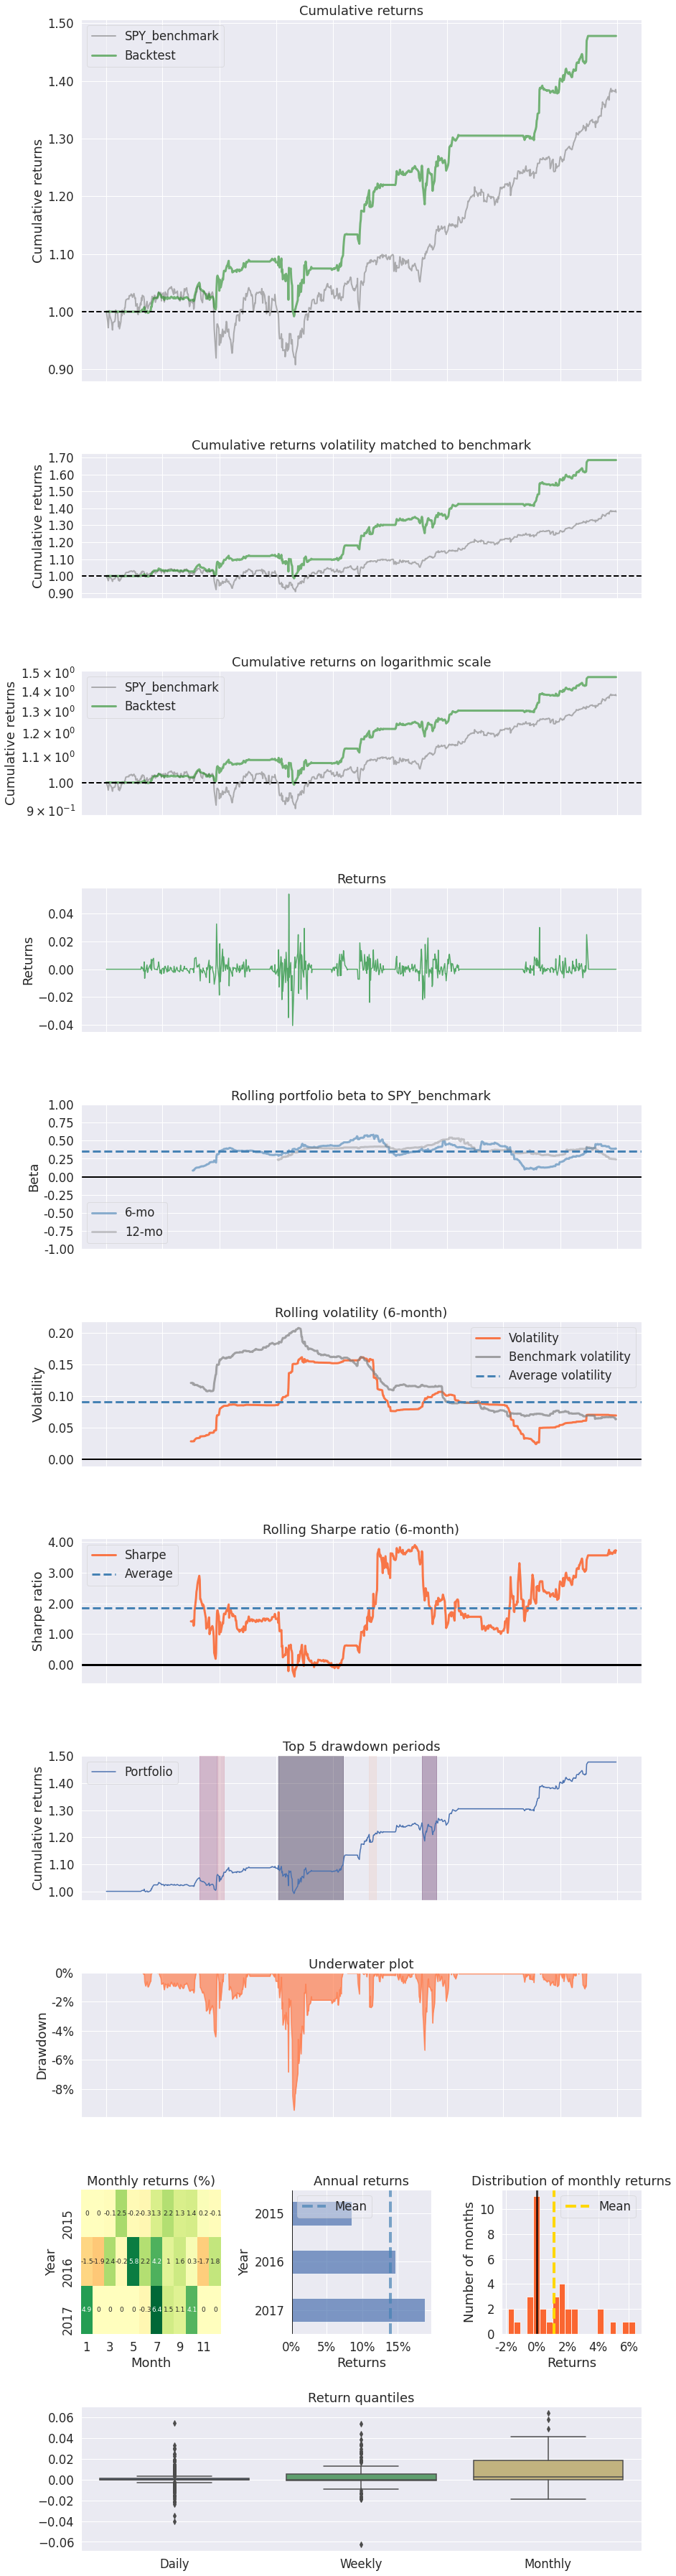

In [ ]:
# Plotting tear sheet (simple/extended)
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt
import warnings
import matplotlib.cbook
warnings.simplefilter('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=matplotlib.cbook.mplDeprecation)

#rsi = pd.read_pickle("rsi.pkl")
#pf.create_simple_tear_sheet(rsi.returns);
#pf.create_returns_tear_sheet(rsi.returns);
#pf.create_full_tear_sheet(rsi.returns);

def process_performance(fname):
    perf = pd.read_pickle('{}.pkl'.format(fname))
    perf.to_csv('{}.csv'.format(fname))
    # Normalize the dates
    perf.index = perf.index.normalize()
    return perf

def create_benchmark(fname):
    # benchmark_rets (pd.Series, optional) -- Daily noncumulative returns of the benchmark. This is in the same style as returns.
    dir = 'https://raw.githubusercontent.com/quantopian/zipline/master/zipline/resources/market_data/'
    bench = pd.read_csv(dir+'{}.csv'.format(fname), index_col='date', parse_dates=True, date_parser=lambda col: pd.to_datetime(col, utc=True))
    # Create a series
    bench_series = pd.Series(bench['return'].values, index=bench.index)
    bench_series.rename(fname, inplace=True)
    return bench_series

# Use PyFolio to generate a performance report - benchmark_rets is optional
def analyze(perfdata, benchdata):
    returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(perfdata)
    #pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions, benchmark_rets=benchdata)
    pf.create_returns_tear_sheet(returns, benchmark_rets=benchdata)


# Create the performance dataframe
perf = process_performance('rsi')

# Create a benchmark dataframe
bench_series = create_benchmark('SPY_benchmark')

# Filter for the dates in returns to line up the graphs - normalize cleans up the dates
bench_series = bench_series[bench_series.index.isin(perf.index)]

# Run the tear sheet analysis
analyze(perf, bench_series)

## $\text{Portfolio Optimization}$

In [ ]:
# Available solvers on CVXPY
import cvxpy
cvxpy.installed_solvers()

['CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCS']

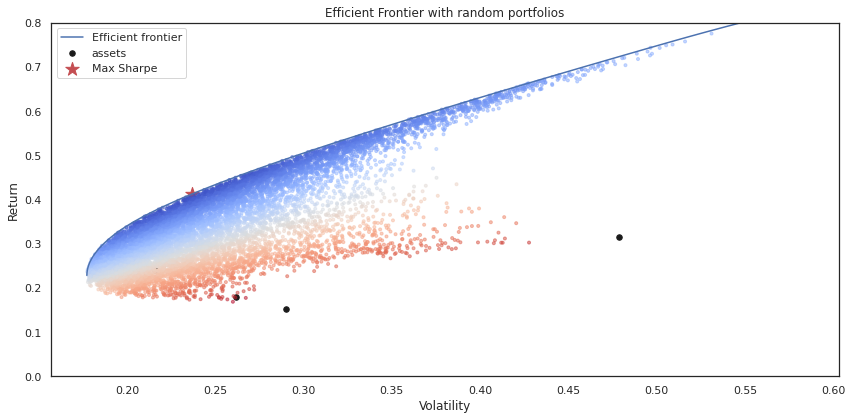

In [ ]:
# Visualizing the Efficient Forntier 
from pypfopt import plotting

mu = pypfopt.expected_returns.mean_historical_return(df)

ef = pypfopt.EfficientFrontier(expected_returns = mu,
                               cov_matrix=cov_matrix,
                               weight_bounds=(0, 1), 
                               solver='SCS',
                               verbose=False)

fig, ax = plt.subplots(figsize=(12, 6))
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=200, c="r", label="Max Sharpe")

# Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(mu)), n_samples)
rets = w.dot(mu)
stds = np.sqrt(np.diag(w @ cov_matrix @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="coolwarm_r", alpha=.5)

# Output
ax.set_title("Efficient Frontier with random portfolios"); ax.legend()
plt.ylim(0, .8); plt.tight_layout();

### $\text{Part II}$

- Comment on the output of the simulation
- Extract the value of the portfolio with ```max Sharpe```, what is the return and the volatility (the values corresponding to the x and y axes of the above graph)
- Determine the share of each portfolio and use it for back testing in the next task.

In [ ]:
dict(ef.clean_weights())

{'AAPL': 0.25514, 'AMZN': 0.0, 'FB': 0.0898, 'GOOG': 0.35101, 'NFLX': 0.30405}

## $\text{Backtesting II}$

After finding the best allocation of portfolio for each stock, run the Backtesting I cell after changing the ```target_pct_per_stock``` and assess the outcome of the RSI strategy.